# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statistics

# Create Toy Dataset

### Parameters and variables

In [6]:
# Output path for the toy dataset
output_path_toy = "/content/drive/MyDrive/OptionalProject/MIMIC_data_labels_toy.csv"

# Number of timesteps in the timeseries
TIMESTEPS = 10
# Number of patients to generate
RECORDS = 400
# Show timeseries plots when generating
VERBOSE = False

# Define the static features and the label
label = ['0', '1']
gender_values = ['M', 'F']
age_values = list(range(18, 99, 1))
insurance_values = ['Other', 'Medicare', 'Medicaid']

static_feat = ['gender', 'Age', 'insurance', 'label']


# Define continuous features
cont_feat = ['F1_constant', 'F2_early', 'F3_late', 'F4_narrow', 'F5_wide']

### Helper funtions

In [7]:
def logistic_function(x, a, b):
    return 1 / (1 + np.exp(-(a * x + b)))


def generate_y(early=True):
    # TODO: Make this dependent on the timesteps, not fixed

    data = np.array([0, 0, 0, 0, 0.3, 0.5, 0.7, 1, 1, 1])
    assert len(data) == TIMESTEPS, 'Change length of y_data'

    if early:
        y_data = data
    else:
        y_data = 1 - data

    return y_data


def show(x_data, y_data, y_constant):

    # Plot the points and logistic function
    plt.scatter(x_data, y_data, color='red', label='Data Points')
    plt.scatter(x_data, y_constant, color='red')
    plt.plot(x_data, y_data, color='blue', label='Label1')
    plt.plot(x_data, y_constant, color='green', label='Label0')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    # Display the plot
    plt.show()


def generate_continuous_function(early, verbose=False):

    # Define the points
    x_data = np.array(range(0, TIMESTEPS))
    y_data = generate_y(early)

    def loss_function(params):
        a, b = params
        y_pred = logistic_function(x_data, a, b)
        loss = -np.mean(y_data * np.log(y_pred) + (1 - y_data) * np.log(1 - y_pred))
        return loss

    # Perform logistic regression using minimize
    initial_params = np.zeros(2)  # Initial guess for parameters
    result = minimize(loss_function, initial_params, method='SLSQP')

    # Retrieve the optimized parameters
    params = result.x

    # Generate points to plot the logistic function
    y_data = logistic_function(x_data, params[0], params[1])

    x_coord = np.random.uniform(low=-2.0, high=2.0, size=None)
    y_data += x_coord
    y_constant = np.full(TIMESTEPS, min(y_data))

    if verbose:
        show(x_data, y_data, y_constant)

    return y_constant, y_data


def constant_function(verbose, gender):

    if gender == 'M':
        m = np.random.uniform(low=0, high=0.5, size=None)
    else:
        m = np.random.uniform(low=1.5, high=2, size=None)

    x_data = np.array(range(0, TIMESTEPS, 1))
    y_data = m * x_data

    if gender == 'M':
        x_coord = np.random.uniform(low=-2.0, high=0, size=None)
    else:
        x_coord = np.random.uniform(low=0, high=2.0, size=None)

    y_data += x_coord
    y_constant = np.full(TIMESTEPS, min(y_data))

    if verbose:
        show(x_data, y_data, y_constant)

    return y_constant, y_data


def early_late_function(early, verbose):

    var0, var1 = generate_continuous_function(early=early, verbose=verbose)
    return var0, var1


def wave_function(narrow, verbose):

    resolution = TIMESTEPS * 2 # how many datapoints to generate
    x_data = np.array(range(0, resolution, 1))

    cycles = 4 if narrow else 2

    length = np.pi * 2 * cycles
    y_data = np.sin(np.arange(0, length, length / resolution))

    x_coord = np.random.uniform(low=-2.0, high=2.0, size=None)
    y_data += x_coord
    y_constant = np.full(resolution, statistics.median(sorted(y_data)))
    start = np.random.choice(TIMESTEPS)
    y_constant = y_constant[start: start+TIMESTEPS]
    y_data = y_data[start: start+TIMESTEPS]
    x_data = x_data[start: start+TIMESTEPS]

    if verbose:
        show(x_data, y_data, y_constant)

    return y_constant, y_data


def populate_df(n_rows, cont_feat, static_feat, verbose=False):

    timesteps = range(TIMESTEPS)
    cont_mi = pd.MultiIndex.from_product([timesteps, cont_feat])
    timestep = [-1]

    mi = cont_mi.append(pd.MultiIndex.from_product([timestep, static_feat]))
    df = pd.DataFrame(columns = mi)

    label_index = 0
    for idx in range(n_rows):
        if idx >= n_rows // 2:
            label_index = 1

        l = label[label_index]

        f2 = early_late_function(True, verbose)[label_index]
        f3 = early_late_function(False, verbose)[label_index]
        f4 = wave_function(True, verbose)[label_index]
        f5 = wave_function(False, verbose)[label_index]
        cont = [f2, f3, f4, f5]

        # Create a balanced dataset regarding gender
        if idx % 2 == 0:
            g = 'M'
        else:
            g = 'F'
        # g = gender_values[np.random.choice(len(gender_values))]

        a = age_values[np.random.choice(len(age_values))]
        i = insurance_values[np.random.choice(len(insurance_values))]
        static = [g, a, i, l]

        f1 = constant_function(verbose, g)[label_index]
        cont.insert(0, f1)

        for t in range(TIMESTEPS):
            for j in range(len(cont_feat)):
                df.loc[idx, (t, cont_feat[j])] = cont[j][t]

        for k in range(len(static_feat)):
            df.loc[idx, (-1, static_feat[k])] = static[k]

        df[(-1, 'label')] = df[(-1, 'label')].astype(int)

        if verbose:
            print("Gender: {}, Age: {}, Insurance: {}, Label: {}".format(g, a, i, l))

    df = df.sample(frac=1).reset_index(drop=True)

    return df

### Creation and saving

In [ ]:
df = populate_df(RECORDS, cont_feat, static_feat, verbose=VERBOSE)
df.to_csv(output_path_toy, index=False)
df.head(10)

# Plot predicted data or generated data

In [2]:
# pred_data_path = "/content/drive/MyDrive/OptionalProject/predicted_data.csv"
# pred_data_path = "/content/drive/MyDrive/OptionalProject/predicted_data_1feat.csv"
# pred_data_path = "/content/drive/MyDrive/OptionalProject/predicted_data_1feat_randominit.csv"
# pred_data_path = "/content/drive/MyDrive/OptionalProject/predicted_data_1feat_labelenc.csv"
# pred_data_path = "/content/drive/MyDrive/OptionalProject/predicted_data_1feat_labelenc_randominit_rmse.csv"
# pred_data_path = "/content/drive/MyDrive/OptionalProject/predicted_data_1feat_labelenc_rmse.csv"
# pred_data_path = "/content/drive/MyDrive/OptionalProject/predicted_data_labelenc_randominit_rmse.csv"
# pred_data_path = "/content/drive/MyDrive/OptionalProject/predicted_data_labelenc_notarget_randominit.csv"
pred_data_path = "/content/drive/MyDrive/OptionalProject/generated_data_labelenc_notarget_randominit.csv"

gt_test_data_path = "/content/drive/MyDrive/OptionalProject/GT_test_data.csv"

timesteps = 10
features = ['F1_constant', 'F2_early', 'F3_late', 'F4_narrow', 'F5_wide']
nr_patients = 5

In [3]:
df = pd.read_csv(pred_data_path, header=[0, 1])
gt_df = pd.read_csv(gt_test_data_path, header=[0, 1])
df.head()

0                                                   1            \
  F1_constant  F2_early   F3_late F4_narrow   F5_wide F1_constant  F2_early   
0    0.054037  0.006443 -0.248596 -0.092075 -0.002420    0.213910 -0.112646   
1    0.058815  0.013130 -0.241590 -0.110175 -0.016562    0.182155 -0.139690   
2    0.057484  0.011257 -0.239138 -0.107678 -0.008943    0.190168 -0.128788   
3    0.059195  0.017143 -0.242664 -0.105661 -0.010908    0.190942 -0.121098   
4    0.057203  0.011603 -0.251382 -0.091278 -0.006308    0.230339 -0.010145   

                                 ...         8           9            \
    F3_late F4_narrow   F5_wide  ...   F5_wide F1_constant  F2_early   
0 -0.239349 -0.160116 -0.330045  ...  0.077029    3.847166  1.150233   
1 -0.212481 -0.192064 -0.336853  ...  0.085768    3.787842  1.158893   
2 -0.212831 -0.182536 -0.323448  ...  0.089564    3.775017  1.161702   
3 -0.215590 -0.180674 -0.325950  ...  0.080793    3.757533  1.153988   
4 -0.216544 -0.127739 -0.252189  ... -0.058392    3.536596  1.064416   

                                    -1                            
    F3_late F4_narrow   F5_wide gender       Age insurance label  
0 -0.906724 -0.507922  0.165345      M -0.272788  Medicare   Yes  
1 -0.894546 -0.562207  0.173249      F -0.192217  Medicare   Yes  
2 -0.902226 -0.553542  0.178446      F -0.211241  Medicare   Yes  
3 -0.913828 -0.553301  0.170111      F -0.218996  Medicare   Yes  
4 -0.851628 -0.497396  0.030678      M -0.324312     Other   Yes  

[5 rows x 54 columns]

In [5]:
def plot_generated(df, timesteps, features, nr_patients):

    indexes = [str(i) for i in range(0, timesteps - 1)]
    cont_df = df.loc[:, pd.IndexSlice[indexes, :]]

    for i in range(nr_patients):
        fig, ax = plt.subplots(1, len(features), figsize=(15, 4))

        # Take labels from timestep 0 to end (on index 0 there is the aggregate label)
        label = np.array(df.xs('label', level = 1, axis = 1).loc[i].values[1:])

        for j, f in enumerate(features):
            if len(features) == 1:
                pos = ax
            else:
                pos = ax[j]
            y = cont_df.xs(f, level = 1, axis = 1).loc[i].values
            x = list(range(0, timesteps - 1))

            pos.scatter(np.array(x), np.array(y), color='gray')
            pos.plot(x, y, color='red', label='Generated')

            pos.set_xlabel('x')
            pos.set_ylabel('y')
            pos.set_title(f"{f}_{i}")
            pos.set_ylim([-2.5, 2.5])
            pos.legend()

        plt.tight_layout()
        plt.show()

def plot_predicted_vs_gt(df, gt_df, timesteps, features, nr_patients):

    indexes = [str(i) for i in range(0, timesteps - 1)]
    cont_df = df.loc[:, pd.IndexSlice[indexes, :]]
    cont_df_gt = gt_df.loc[:, pd.IndexSlice[indexes, :]]

    for i in range(nr_patients):
        fig, ax = plt.subplots(1, len(features), figsize=(15, 4))

        # Take labels from timestep 0 to end (on index 0 there is the aggregate label)
        label = np.array(df.xs('label', level = 1, axis = 1).loc[i].values[1:])
        label_gt = gt_df.xs('label', level = 1, axis = 1).loc[i].values[0]
        wrong_idx = np.where(label[:-1] != label_gt)

        for j, f in enumerate(features):
            if len(features) == 1:
                pos = ax
            else:
                pos = ax[j]
            y = cont_df.xs(f, level = 1, axis = 1).loc[i].values
            y_gt = cont_df_gt.xs(f, level = 1, axis = 1).loc[i].values
            x = list(range(0, timesteps - 1))

            pos.scatter(np.array(x), np.array(y), color='gray')
            pos.plot(x, y, color='red', label='Predicted')
            pos.scatter(x, y_gt, color='gray')
            pos.plot(x, y_gt, color='green', label='GT')

            # Plot wrong preds
            if len(wrong_idx) > 0:
                pos.scatter(wrong_idx, np.array(y)[wrong_idx], color='blue', label='Wrong prediction')
                pos.scatter(wrong_idx, np.array(y_gt)[wrong_idx], color='blue')

            pos.set_xlabel('x')
            pos.set_ylabel('y')
            pos.set_title(f"{f}_{i}")
            pos.set_ylim([-2.5, 2.5])
            pos.legend()

        plt.tight_layout()
        plt.show()

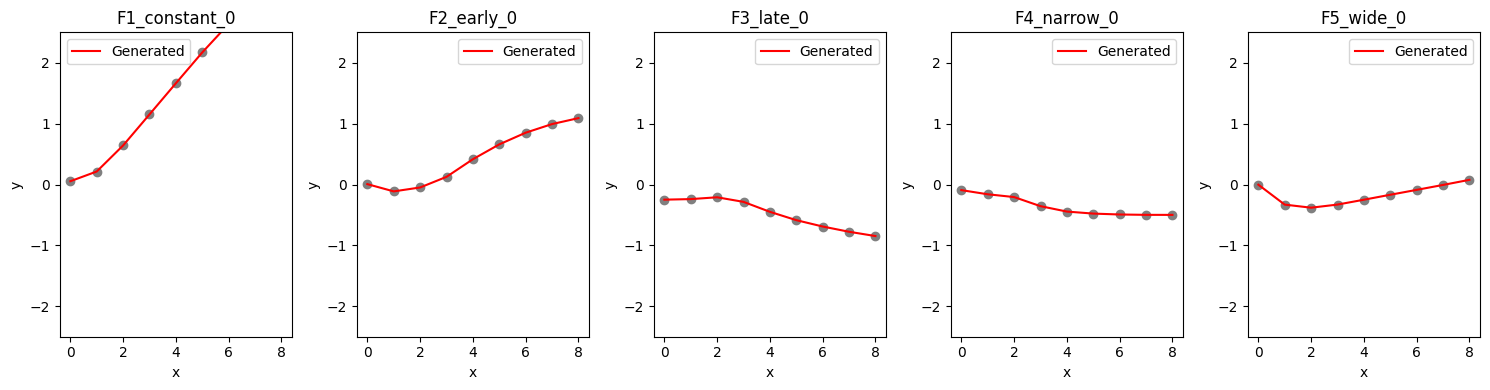

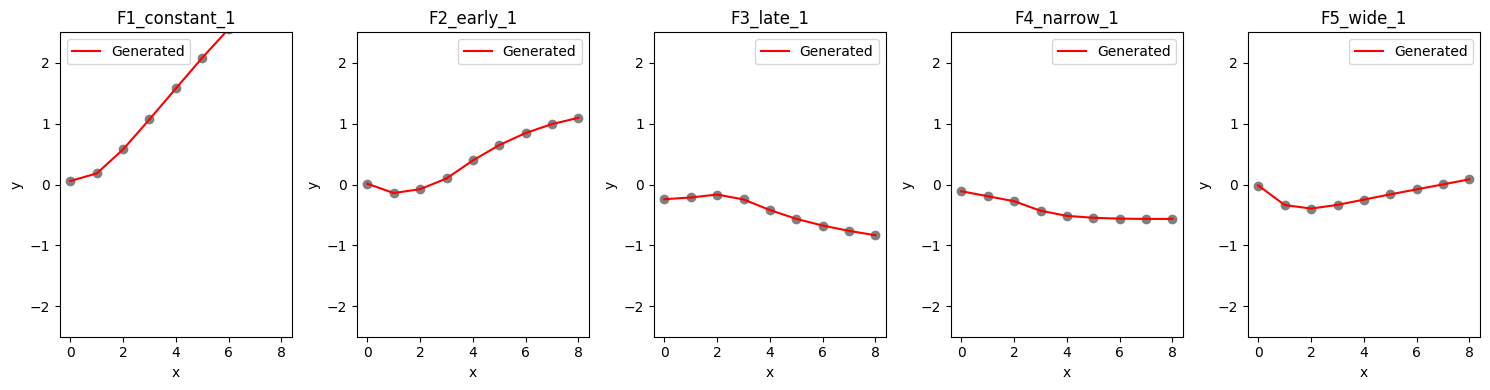

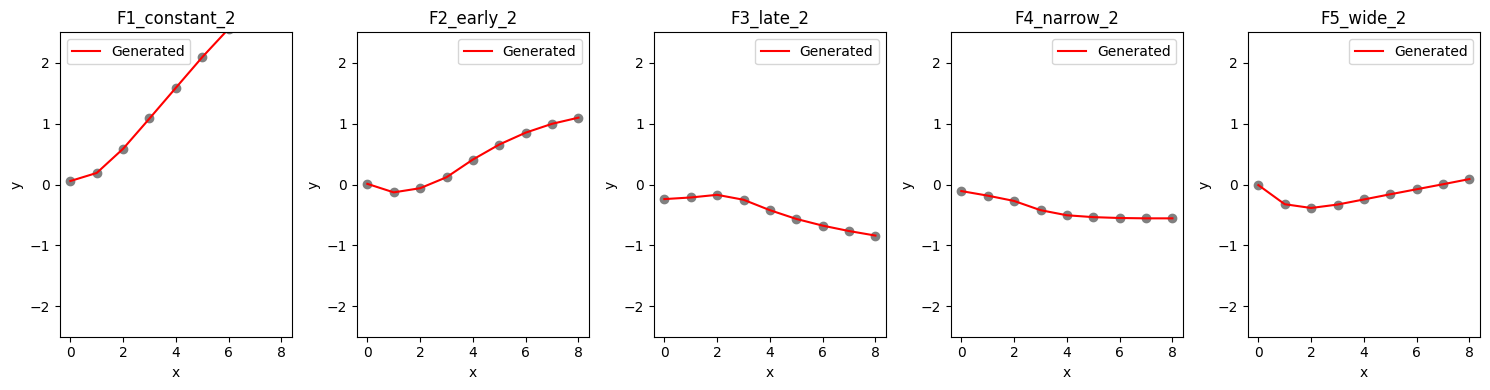

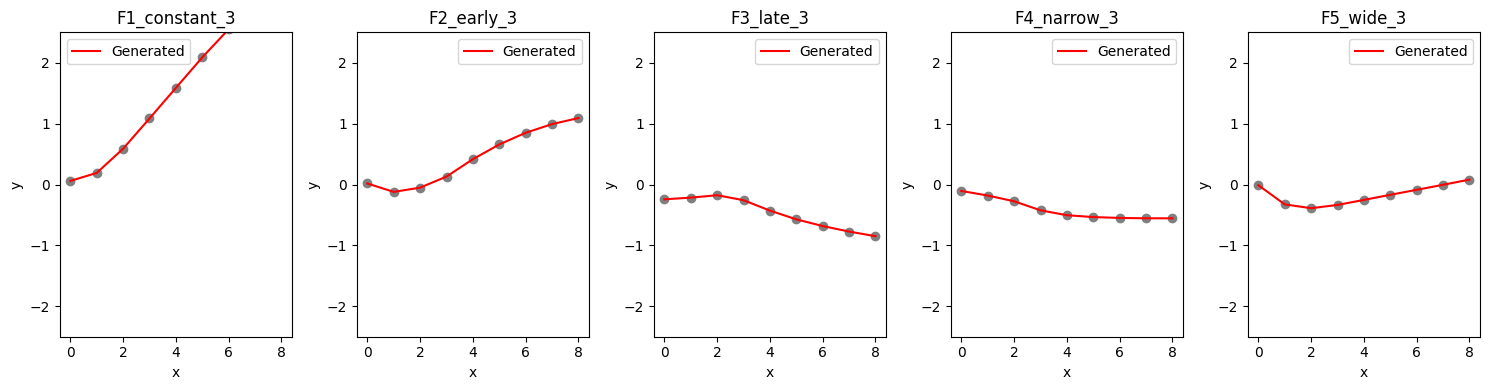

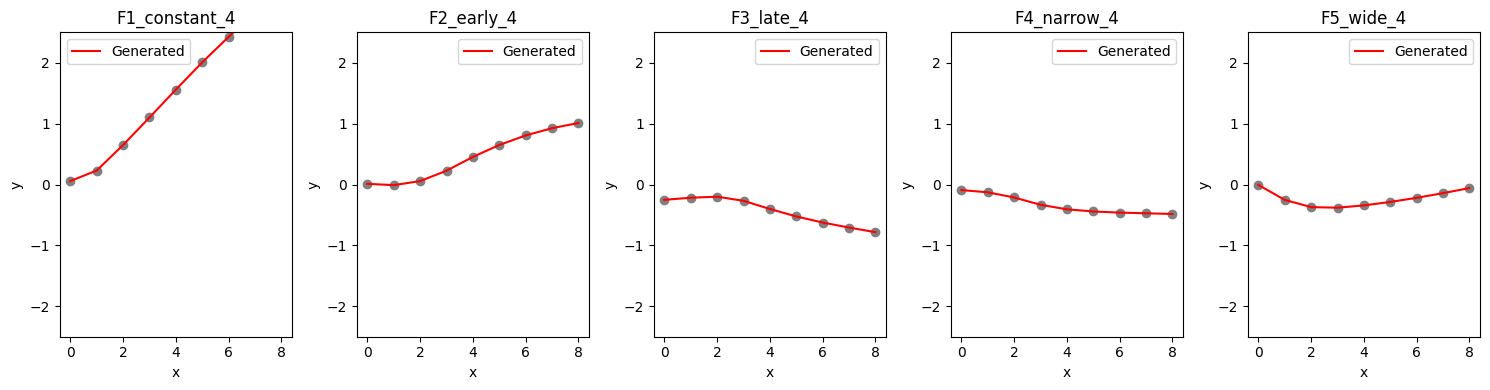

In [7]:
# plot_predicted_vs_gt(df, gt_df, timesteps, features, nr_patients)
plot_generated(df, timesteps, features, nr_patients)

# Plot MIMIC small continuous distribution


In [2]:
mimic_data_path = "/content/drive/MyDrive/OptionalProject/MIMIC_data_labels_small.csv"

mimic_feats = ['WBC', 'Chloride (serum)', 'Glucose (serum)', 'Magnesium', 'Sodium (serum)', 'BUN', 'Phosphorous',
                     'Anion gap', 'Potassium (serum)', 'HCO3 (serum)', 'Platelet Count', 'Prothrombin time', 'PTT',
                     'Lactic Acid']

timesteps = 48

In [ ]:
df = pd.read_csv(mimic_data_path, header=[0, 1])

indexes = [str(i) for i in range(0, timesteps)]
cont_df = df.loc[:, pd.IndexSlice[indexes, :]]

label = df.xs('label', level = 1, axis = 1)['-1'].values.astype(bool)
pos_data = cont_df.loc[label].reset_index(drop=True)
neg_data = cont_df.loc[~label].reset_index(drop=True)


for j, f in enumerate(mimic_feats):
    feat_data_pos = np.empty(shape=(pos_data.shape[0], timesteps))
    feat_data_neg = np.empty(shape=(neg_data.shape[0], timesteps))

    for i in range(pos_data.shape[0]):
        feat_data_pos[i] = pos_data.xs(f, level = 1, axis = 1).loc[i].values
    for i in range(neg_data.shape[0]):
        feat_data_neg[i] = neg_data.xs(f, level = 1, axis = 1).loc[i].values

    feat_data_mean_pos = np.nanmean(feat_data_pos, axis=0)
    feat_data_mean_neg = np.nanmean(feat_data_neg, axis=0)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(pd.DataFrame(feat_data_mean_pos).rolling(12).mean(), label='Smoothed positive', color='red')
    ax[1].plot(pd.DataFrame(feat_data_mean_neg).rolling(12).mean(), label='Smoothed negative', color='red')
    # ax[0].plot(feat_data_mean_pos, label='Original', color='blue')
    # ax[1].plot(feat_data_mean_neg, label='Original', color='blue')
    ax[0].set_title(f"Mean {f} - positive patients across time")
    ax[1].set_title(f"Mean {f} - negative patients across time")
    ax[0].legend()
    ax[1].legend()

    plt.tight_layout()
    plt.show()